In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Linear advection equation 

We want to solve the two-dimensional linear equation:

$\displaystyle\frac{\partial a}{\partial t} + u \displaystyle\frac{\partial a}{\partial x}+v \displaystyle\frac{\partial a}{\partial y}=0$,

where $u$ and $v$ are constants. This equation simply displaces the initial condition $a(x,y,t=0)$ by a speed $u$ in the $x$ direction and a speed $v$ in the $y$ direction, such that the exact solution is readily available.

## Second order solver with fluxes

We will now follow the second order method outlined in Chapter 5.

### Code

We write down routines to create the grid, set the boundary conditions and initialize the state separately

In [2]:
def create_grid(ni,di):
    return np.arange(ni)*di

In [3]:
def set_periodic_bc(mm):
    mm[0,:]=mm[-1,:]
    mm[:,0]=mm[:,-1]
    return mm

In [23]:
def initialize_state(nx,ny,dx,dy):
    m=np.zeros([nx,ny])
    ilx=int(.333/dx)
    irx=int(.666/dx)
    ily=int(.333/dy)
    iry=int(.666/dy)
    m[ilx:irx,ily:iry]=1.
    return m

In [24]:
def calculate_timestep(C,u,dx,v,dy):
    return np.min(np.array([dx*C/u,dy*C/v]))

We calculate the  'left' and 'right' states for the ($i\pm1/2,j)$. We will follow Eq. (5.47) for $\partial_x a$, using Strang splitting. We can use our previous solvers, but modify the arrays to become 2-D.

In [25]:
def calculate_aL_x(a,u,dt,dx):
    da=(np.roll(a,-1,axis=0)-np.roll(a,1,axis=0))/(2.*dx)
    return a[:-1,:]+dx/2.*(1.-dt/dx*u)*da[:-1,:]

In [26]:
def calculate_aR_x(a,u,dt,dx):
    da=(np.roll(a,-1,axis=0)-np.roll(a,1,axis=0))/(2.*dx)
    return a[1:,:]-dx/2.*(1.+dt/dx*u)*da[1:,:]

We calculate the  'left' and 'right' states for the ($i,j\pm1/2)$ with Strang splitting, it becomes the same as earlier.

In [27]:
def calculate_aL_y(a,v,dt,dy):
    da=(np.roll(a,-1,axis=1)-np.roll(a,1,axis=1))/(2.*dy)
    return a[:,:-1]+dy/2.*(1.-dt/dy*v)*da[:,:-1]

In [38]:
def calculate_aR_y(a,v,dt,dy):
    da=(np.roll(a,-1,axis=1)-np.roll(a,1,axis=1))/(2.*dy)
    return a[:,1:]-dy/2.*(1.+dt/dy*v)*da[:,1:]

We solve the Riemann problem for the x-direction according to (5.10)

In [35]:
def solve_Riemann_x(aLx,aRx,u):
    flux=aL*u
    if (u<0):
        flux=aR*u
    return flux

In [36]:
def solve_Riemann_y(aLy,aRy,v):
    flux=aL*v
    if (v<0):
        flux=aR*v    
    return flux

We will run the equation between $t_0=0$ and $t_\max=1$, and set $u=v=1$. We will solve this in a periodic, unit square. All of this means that our initial solution will have travelled by one period in both x- and y, so the solution should be the same as the initial condition.

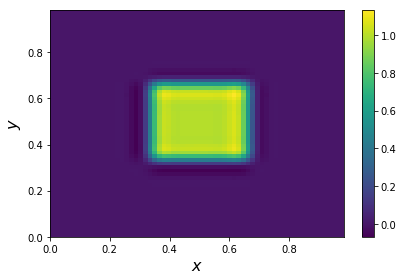

In [44]:
t0=0.; tmax=1.;
nx=64; u=1.;
ny=64; v=1.;
xmin=0.; xmax=1.
dx=(xmax-xmin)/(nx)
x=create_grid(nx+1,dx)
ymin=0.; ymax=1.
dy=(xmax-xmin)/(ny)
y=create_grid(ny+1,dy)
a0=initialize_state(nx+1,ny+1,dx,dy)
a0=set_periodic_bc(a0)
t=t0; nt=0
a=a0.copy()
C=0.9
while t < tmax:
    dt=calculate_timestep(C,u,dx,v,dy)
    if(np.mod(nt,2)==0):  # For strang splitting, we do things differently on odd- and even time-steps
        aL=calculate_aL_x(a,u,dt,dx)
        aR=calculate_aR_x(a,u,dt,dx)
        flux=solve_Riemann_x(aL,aR,u)
        a[1:,:]=a[1:,:]-dt/dx*(np.roll(flux,-1,axis=0)-flux)
        a=set_periodic_bc(a)
        aL=calculate_aL_y(a,v,dt,dx)
        aR=calculate_aR_y(a,v,dt,dx)
        flux=solve_Riemann_y(aL,aR,v)
        a[:,1:]=a[:,1:]-dt/dx*(np.roll(flux,-1,axis=1)-flux)
        a=set_periodic_bc(a)
    else:  
        aL=calculate_aL_y(a,v,dt,dx)
        aR=calculate_aR_y(a,v,dt,dx)
        flux=solve_Riemann_y(aL,aR,v)
        a[:,1:]=a[:,1:]-dt/dx*(np.roll(flux,-1,axis=1)-flux)
        a=set_periodic_bc(a)
        aL=calculate_aL_x(a,u,dt,dx)
        aR=calculate_aR_x(a,u,dt,dx)
        flux=solve_Riemann_x(aL,aR,u)
        a[1:,:]=a[1:,:]-dt/dx*(np.roll(flux,-1,axis=0)-flux)
        a=set_periodic_bc(a)
        
    t += dt
    nt += 1
    
plt.pcolormesh(x[:nx],y[:ny],a[:nx,:ny])
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$y$", fontsize=16)
#plt.gca().axis_equal()
plt.colorbar()
plt.tight_layout()
plt.show()

We now set the velocity $v$ to be different, so the solution will travel slower along the $y$ direction.

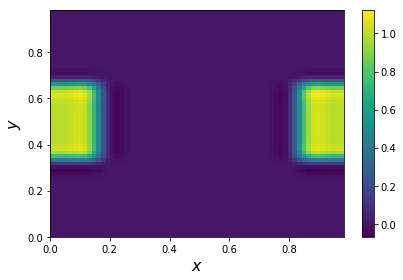

In [64]:
t0=0.; tmax=1.;
nx=64; u=1.;
ny=64; v=0.5;
xmin=0.; xmax=1.
dx=(xmax-xmin)/(nx)
x=create_grid(nx+1,dx)
ymin=0.; ymax=1.
dy=(xmax-xmin)/(ny)
y=create_grid(ny+1,dy)
a0=initialize_state(nx+1,ny+1,dx,dy)
a0=set_periodic_bc(a0)
t=t0; nt=0
a=a0.copy()
C=0.9
while t < tmax:
    dt=calculate_timestep(C,u,dx,v,dy)
    if(np.mod(nt,2)==0):  # For strang splitting, we do things differently on odd- and even time-steps
        aL=calculate_aL_x(a,u,dt,dx)
        aR=calculate_aR_x(a,u,dt,dx)
        flux=solve_Riemann_x(aL,aR,u)
        a[1:,:]=a[1:,:]-dt/dx*(np.roll(flux,-1,axis=0)-flux)
        a=set_periodic_bc(a)
        aL=calculate_aL_y(a,v,dt,dx)
        aR=calculate_aR_y(a,v,dt,dx)
        flux=solve_Riemann_y(aL,aR,v)
        a[:,1:]=a[:,1:]-dt/dx*(np.roll(flux,-1,axis=1)-flux)
        a=set_periodic_bc(a)
    else:  
        aL=calculate_aL_y(a,v,dt,dx)
        aR=calculate_aR_y(a,v,dt,dx)
        flux=solve_Riemann_y(aL,aR,v)
        a[:,1:]=a[:,1:]-dt/dx*(np.roll(flux,-1,axis=1)-flux)
        a=set_periodic_bc(a)
        aL=calculate_aL_x(a,u,dt,dx)
        aR=calculate_aR_x(a,u,dt,dx)
        flux=solve_Riemann_x(aL,aR,u)
        a[1:,:]=a[1:,:]-dt/dx*(np.roll(flux,-1,axis=0)-flux)
        a=set_periodic_bc(a)
        
    t += dt
    nt += 1
    
plt.pcolormesh(x[:nx],y[:ny],a[:nx,:ny])
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$y$", fontsize=16)
#plt.gca().axis_equal()
plt.colorbar()
plt.tight_layout()
plt.show()

## Gaussian initial conditions

Finally, let us try Gaussian initial conditions

In [57]:
def initialize_state_gauss(nx,ny,dx,dy):
    xmin=0.; xmax=1.
    dx=(xmax-xmin)/(nx)
    x=create_grid(nx+1,dx)
    ymin=0.; ymax=1.
    dy=(xmax-xmin)/(ny)
    y=create_grid(ny+1,dy)
    xx,yy=np.meshgrid(x,y)
    m=np.exp(-(((xx-0.5)**2.+(yy-0.5)**2.)/0.03))
    return m

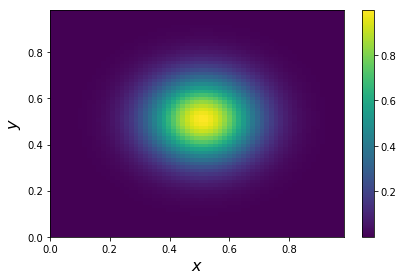

In [58]:
t0=0.; tmax=1.;
nx=64; u=1.;
ny=64; v=1.;
xmin=0.; xmax=1.
dx=(xmax-xmin)/(nx)
x=create_grid(nx+1,dx)
ymin=0.; ymax=1.
dy=(xmax-xmin)/(ny)
y=create_grid(ny+1,dy)
a0=initialize_state_gauss(nx+1,ny+1,dx,dy)
a0=set_periodic_bc(a0)
t=t0; nt=0
a=a0.copy()
C=0.9
while t < tmax:
    dt=calculate_timestep(C,u,dx,v,dy)
    if(np.mod(nt,2)==0):
        aL=calculate_aL_x(a,u,dt,dx)
        aR=calculate_aR_x(a,u,dt,dx)
        flux=solve_Riemann_x(aL,aR,u)
        a[1:,:]=a[1:,:]-dt/dx*(np.roll(flux,-1,axis=0)-flux)
        a=set_periodic_bc(a)
        aL=calculate_aL_y(a,v,dt,dx)
        aR=calculate_aR_y(a,v,dt,dx)
        flux=solve_Riemann_y(aL,aR,v)
        a[:,1:]=a[:,1:]-dt/dx*(np.roll(flux,-1,axis=1)-flux)
        a=set_periodic_bc(a)
    else:  
        aL=calculate_aL_y(a,v,dt,dx)
        aR=calculate_aR_y(a,v,dt,dx)
        flux=solve_Riemann_y(aL,aR,v)
        a[:,1:]=a[:,1:]-dt/dx*(np.roll(flux,-1,axis=1)-flux)
        a=set_periodic_bc(a)
        aL=calculate_aL_x(a,u,dt,dx)
        aR=calculate_aR_x(a,u,dt,dx)
        flux=solve_Riemann_x(aL,aR,u)
        a[1:,:]=a[1:,:]-dt/dx*(np.roll(flux,-1,axis=0)-flux)
        a=set_periodic_bc(a)
        
    t += dt
    nt += 1
    
plt.pcolormesh(x[:nx],y[:ny],a[:nx,:ny])
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$y$", fontsize=16)
#plt.gca().axis_equal()
plt.colorbar()
plt.tight_layout()
plt.show()